In [1]:
import numpy as np


import numpy as np 
import matplotlib.pyplot as plt
import torch 
import ot 
import os

os.chdir("..")
cwd = os.getcwd()
import numba as nb

# import our gw, (bounded) pgw, mpgw 

from lib.gromov import gromov_wasserstein,cost_matrix_d,tensor_dot_param,tensor_dot_func,gwgrad_partial1,partial_gromov_wasserstein,partial_gromov_ver1,GW_dist,MPGW_dist,PGW_dist_with_penalty
from lib.gromov_barycenter import *
# import ugw 
from lib.opt import *
from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn,log_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost
from lib.unbalanced_gromov_wasserstein.unbalancedgw.utils import generate_measure
from lib.unbalanced_gromov_wasserstein.unbalancedgw.batch_stable_ugw_solver import log_batch_ugw_sinkhorn

from ot.utils import dist, UndefinedParameter, list_to_array
from ot.optim import cg, line_search_armijo, solve_1d_linesearch_quad
from ot.utils import check_random_state, unif
from ot.backend import get_backend, NumpyBackend


from pathlib import Path

import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
from sklearn import manifold
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits
from sklearn.manifold import MDS




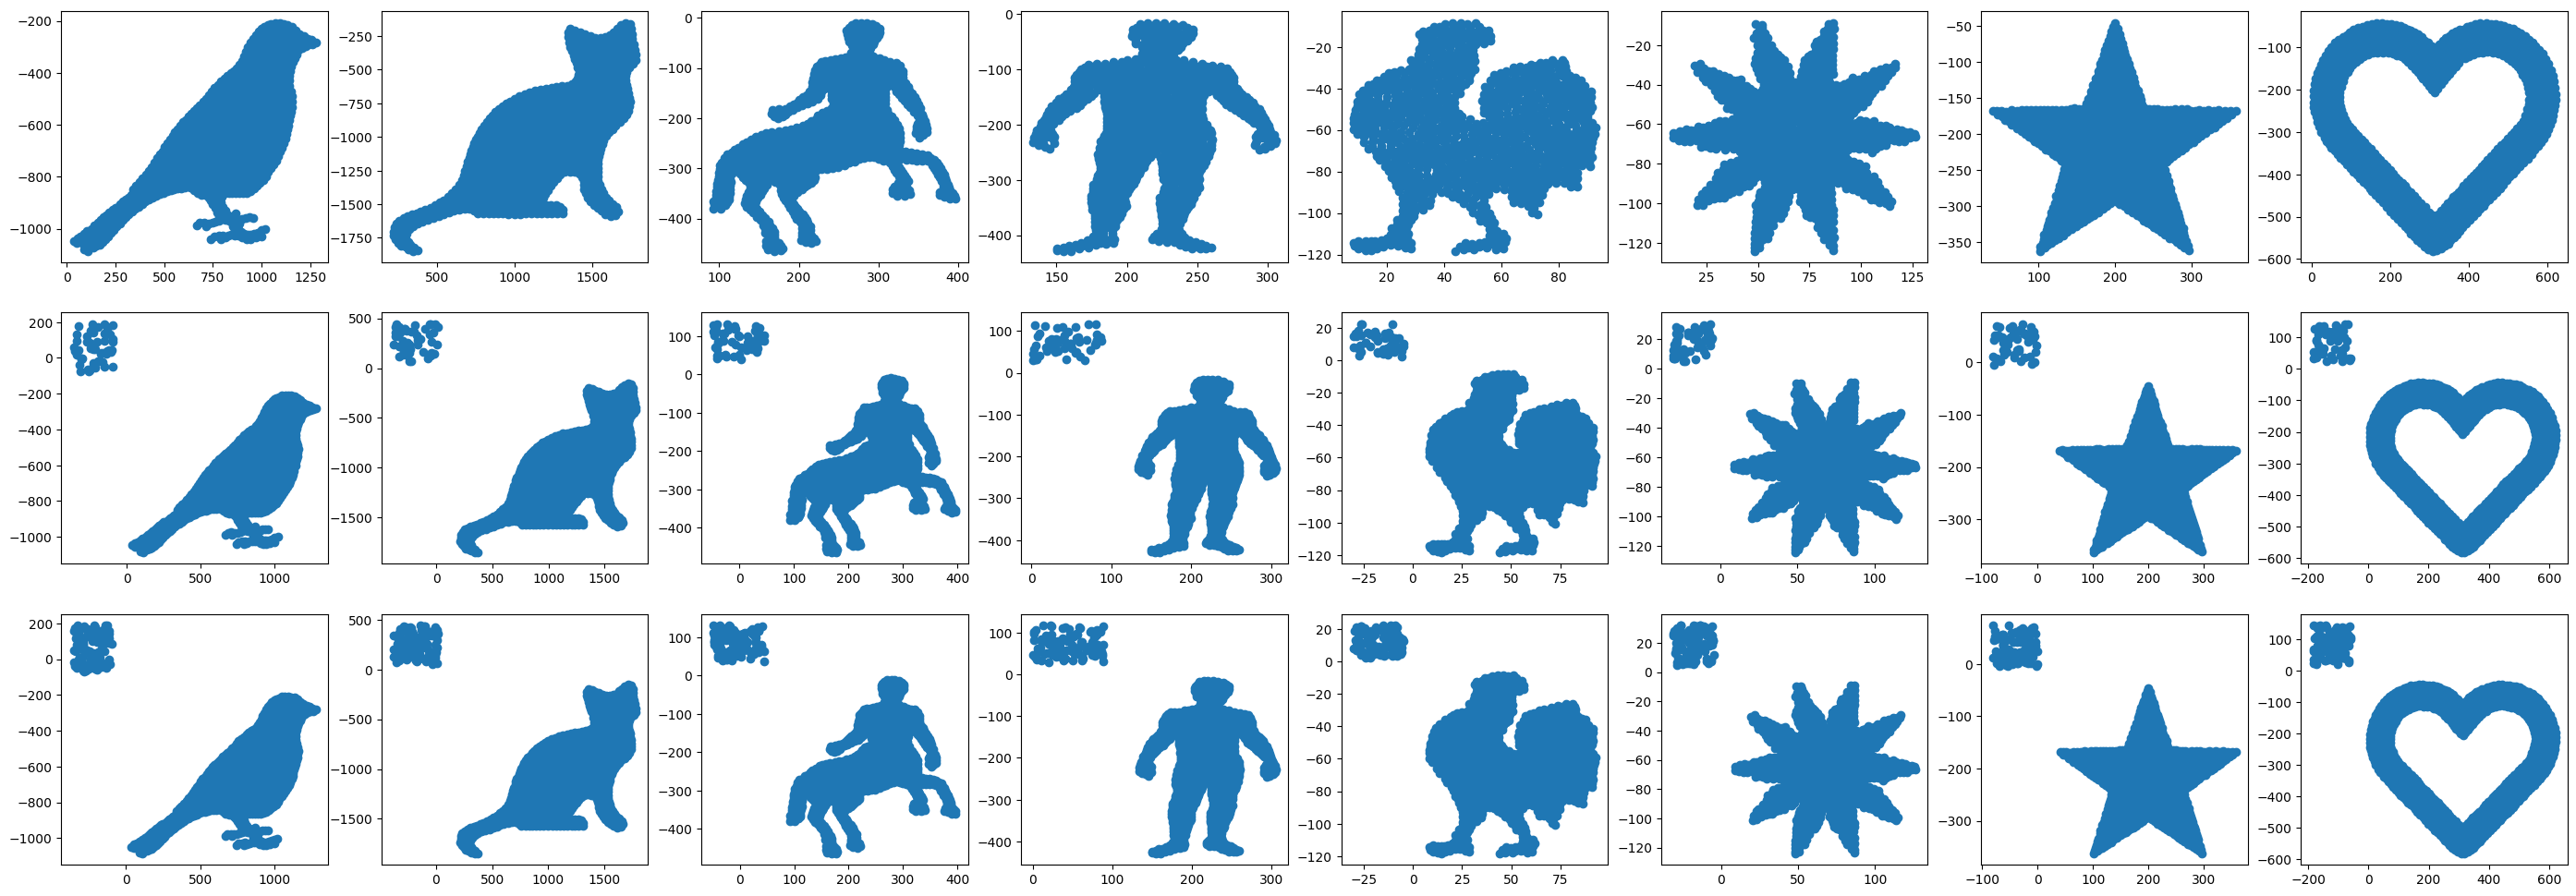

In [3]:
label='p1'
with open('interpolation/data/noise_0_point_cloud_1024.npy', 'rb') as f1:
    noise_0 = np.load(f1)
with open('interpolation/data/noise_%s_5_point_cloud_1024.npy'%label, 'rb') as f2:
    noise_5 = np.load(f2)
with open('interpolation/data/noise_%s_10_point_cloud_1024.npy'%label, 'rb') as f3:
    noise_10 = np.load(f3)
fig, ax = plt.subplots(3, 8, figsize=(35, 12))
for i in range(8):
    ax[0, i].scatter(noise_0[i][:,0], noise_0[i][:,1])
    ax[1, i].scatter(noise_5[i][:,0], noise_5[i][:,1])
    ax[2, i].scatter(noise_10[i][:,0], noise_10[i][:,1])
plt.show()

In [13]:
def embed_d(X,d): # unknown 
    N,k=X.shape
    X1=np.zeros((N,d))
    Min=min(k,d)
    X1[:,0:Min]=X[:,0:Min]
    return X1 

def embed_d2(X,d):#known 
    N,k=X.shape
    X1=np.zeros((N,d))
    Min=min(k,d)
    X1[:,-Min:]=X[:,0:Min]
    return X1 

def rotation_3d(theta):
    """
    Generate a 3D rotation matrix for rotations around the Z-axis by theta1
    and then around the Y-axis by theta2.

    Parameters:
    theta1 (float): Rotation angle around the Z-axis in radians.
    theta2 (float): Rotation angle around the Y-axis in radians.

    Returns:
    numpy.ndarray: The resulting 3x3 rotation matrix.
    """
    # Rotation matrix around the Z-axis
    theta1,theta2=theta[0],theta[1]
    Rz = np.array([
        [np.cos(theta1), -np.sin(theta1), 0],
        [np.sin(theta1),  np.cos(theta1), 0],
        [0,               0,              1]
    ])

    # Rotation matrix around the Y-axis
    Ry = np.array([
        [ np.cos(theta2), 0, np.sin(theta2)],
        [ 0,              1, 0             ],
        [-np.sin(theta2), 0, np.cos(theta2)]
    ])

    # Combined rotation matrix: first Rz, then Ry
    R = Ry @ Rz
    return R

d=4
# construct data 

def rotation_2d(angle):
    """
    Computes a 2D rotation matrix.

    Parameters:
    angle (float): The rotation angle in radians.

    Returns:
    numpy.ndarray: A 2x2 rotation matrix.
    """
    return np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle),  np.cos(angle)]
    ])


X_list,C_list,max_list=[],[],[]

for idx,i in enumerate([0,1,3,4]):
    X=noise_0[i]
    if idx%2==1:
        np.random.seed(idx)
        X1=embed_d2(X,d)
        random_matrix = np.random.randn(d, d)
        q, _ = np.linalg.qr(random_matrix)
        X1=X1.dot(q)
#        print('theta is',theta)
    else:
        X1=X
    C=np.sqrt(cost_matrix_d(X1,X1))
    C_max=C.max()
    max_list.append(C_max)
    X1=X1/C_max
    C1=C/C_max
    X_list.append(X1)
    C_list.append(C1)
    N=X.shape[0]
    p=np.ones(X.shape[0])/N
    p_list.append(p)


    


# construct initial guess

X_init = np.random.rand(N, d)  # initial Dirac locations
C_init=np.sqrt(cost_matrix_d(X_init,X_init))
X_init/=C_init.max()
C_init/=C_init.max()
p_init=np.ones(N)/N

#


In [11]:
C_max

1.0

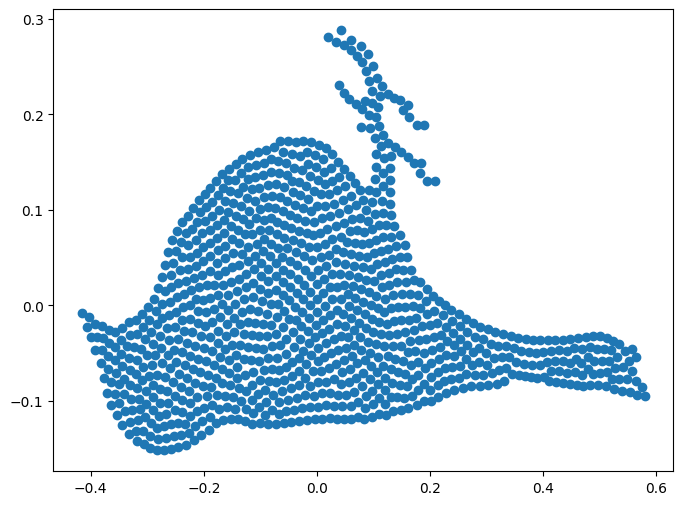

OT done


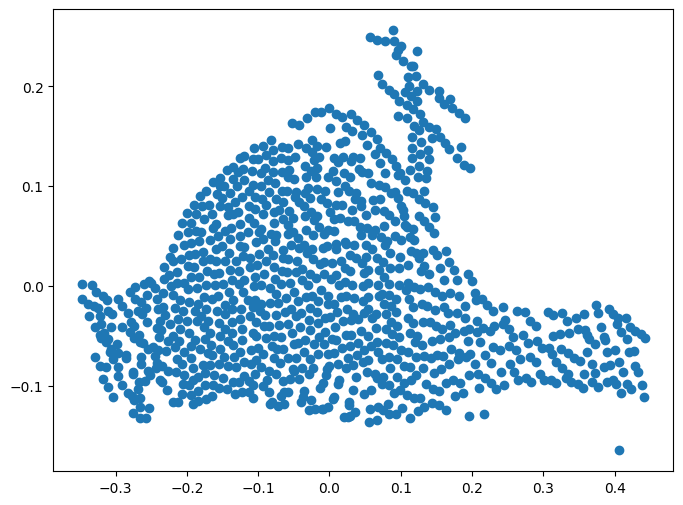

OT done


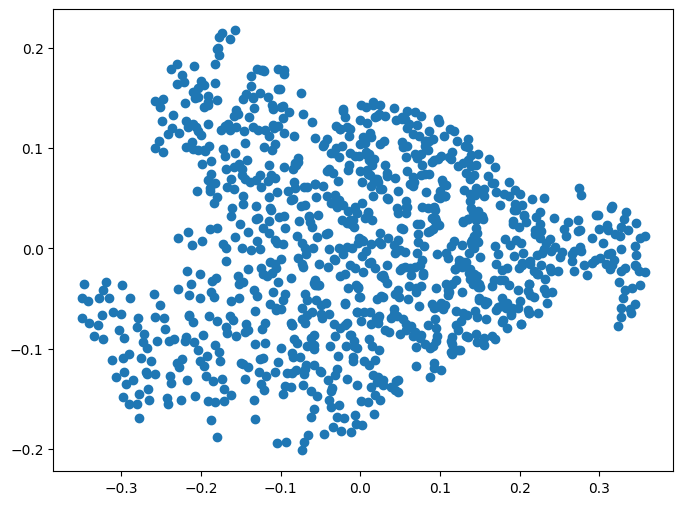

OT done


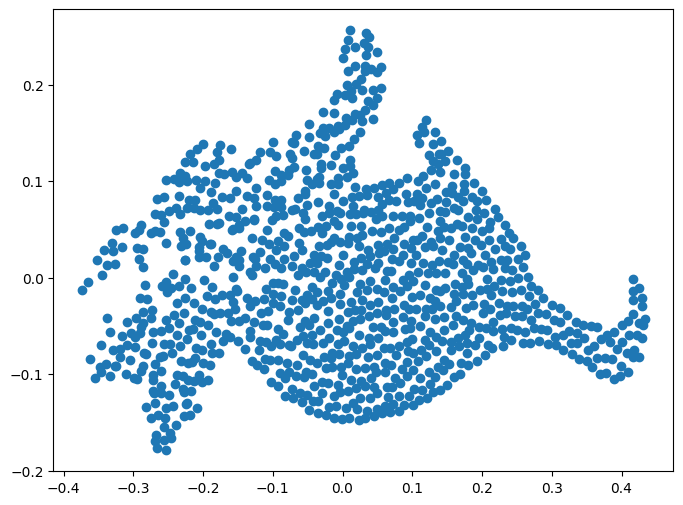

OT done


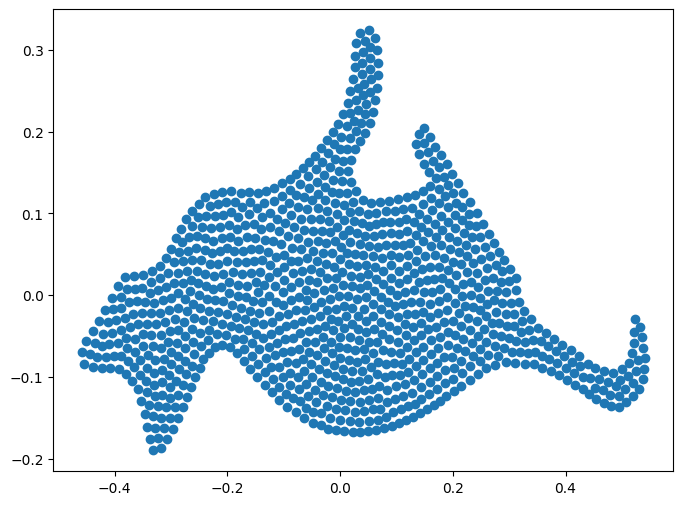

OT done


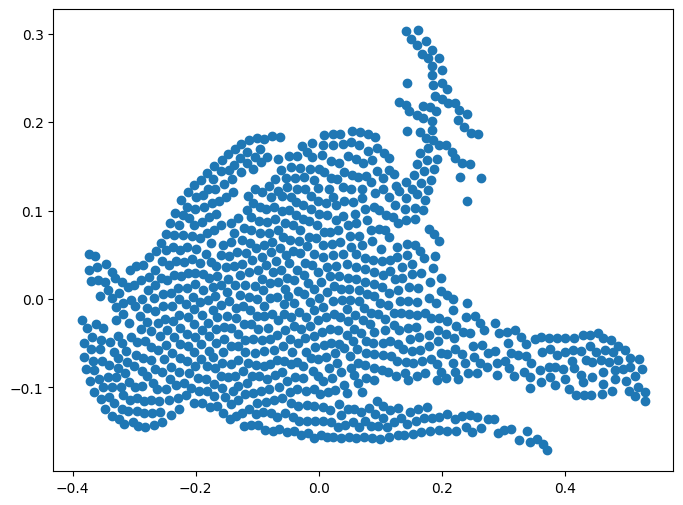

OT done


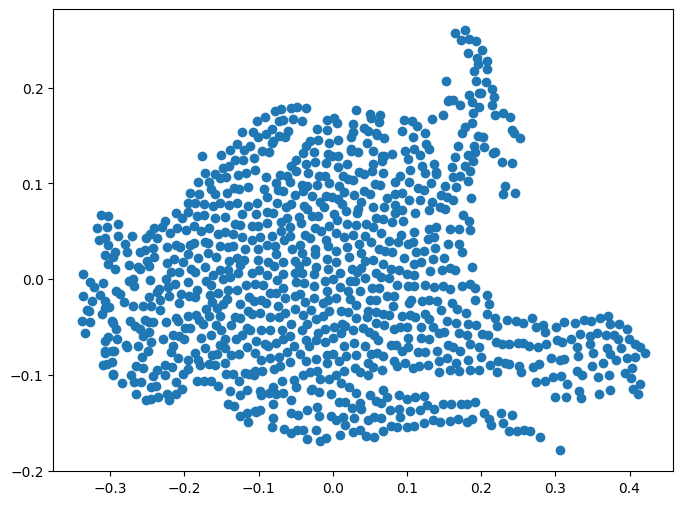

OT done


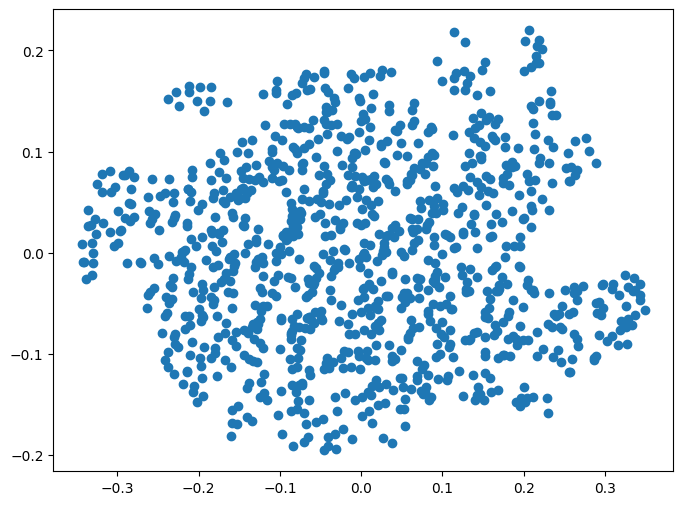

OT done


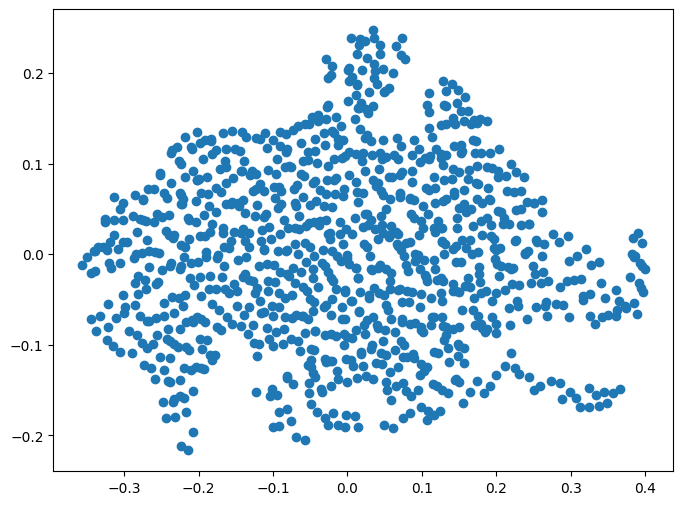

OT done


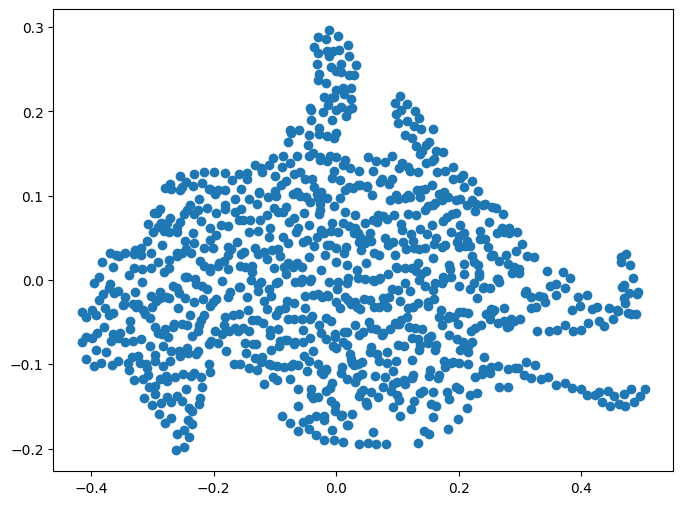

OT done


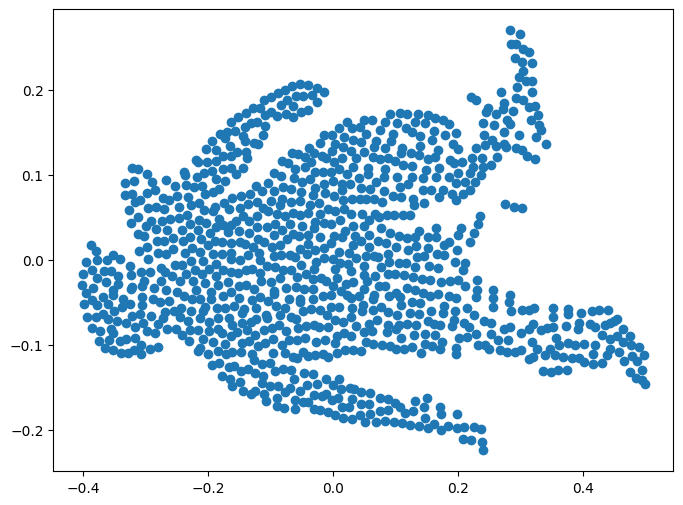

OT done


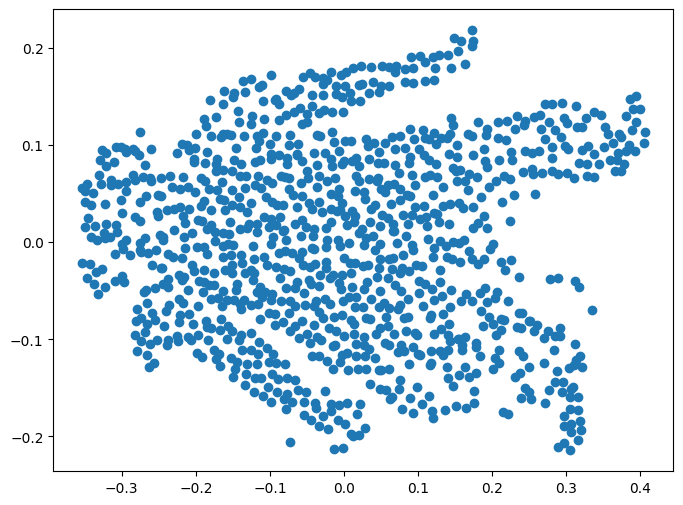

OT done


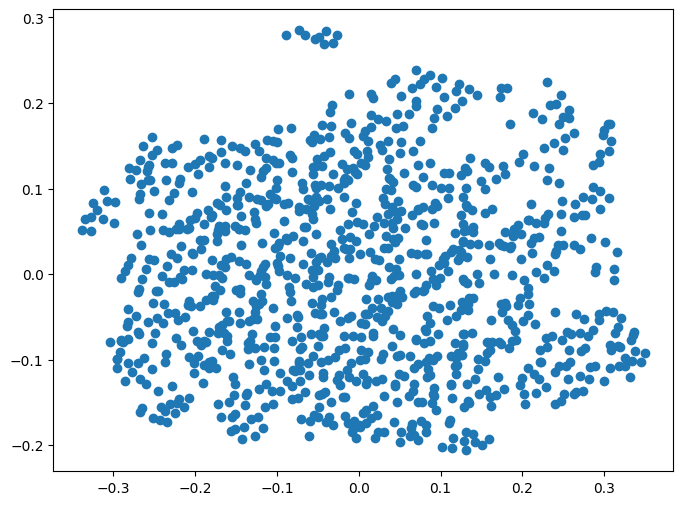

OT done


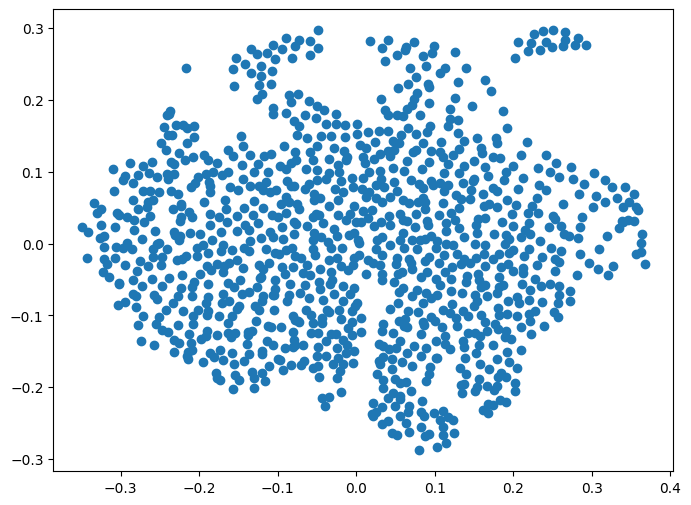

OT done


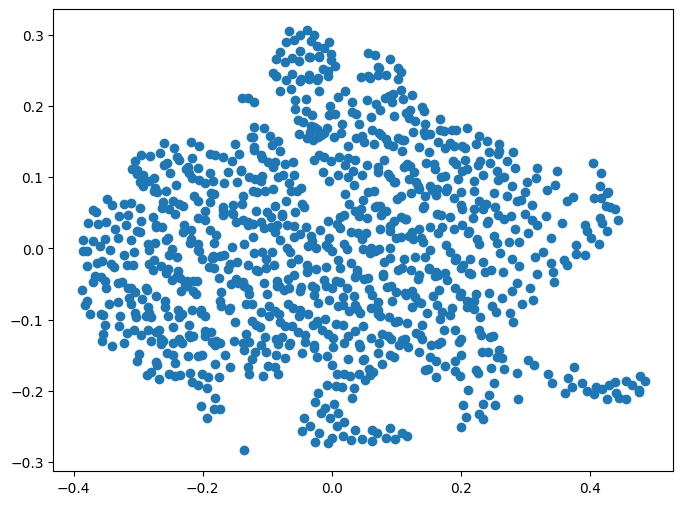

OT done


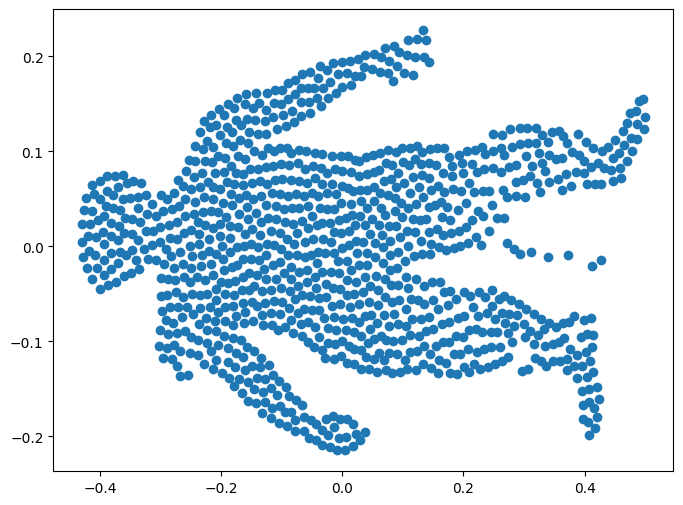

OT done


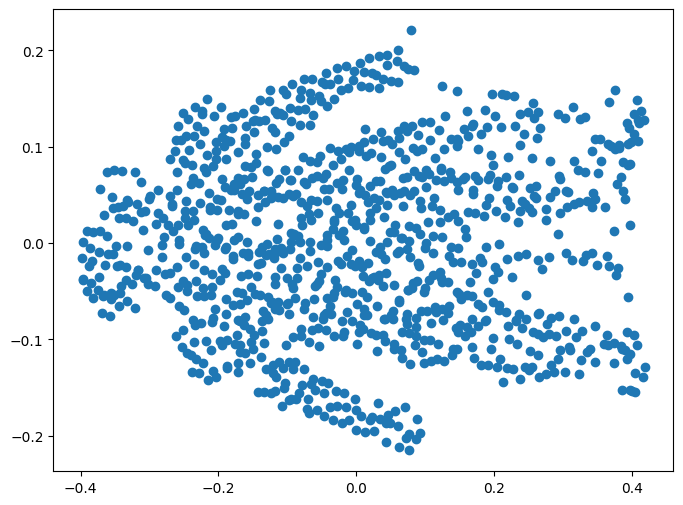

OT done


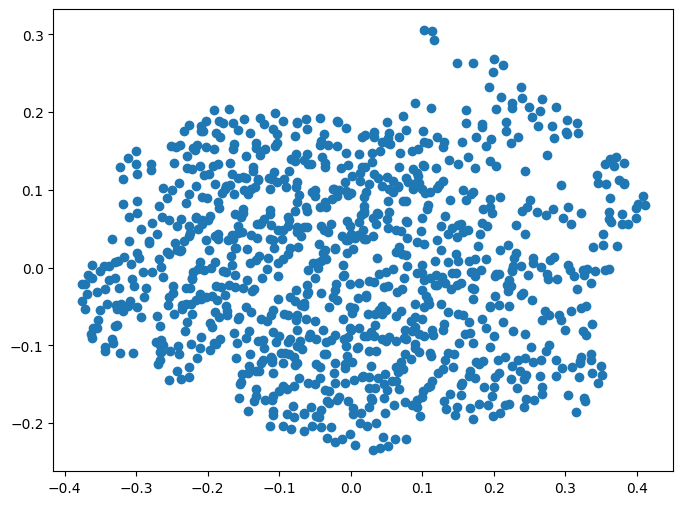

OT done


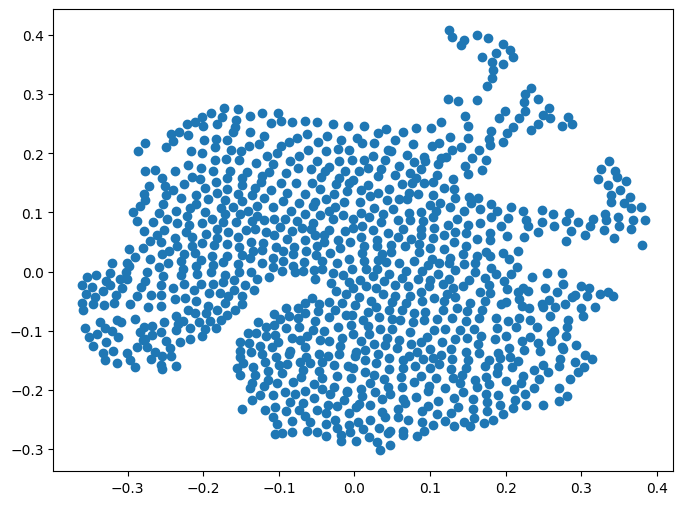

OT done


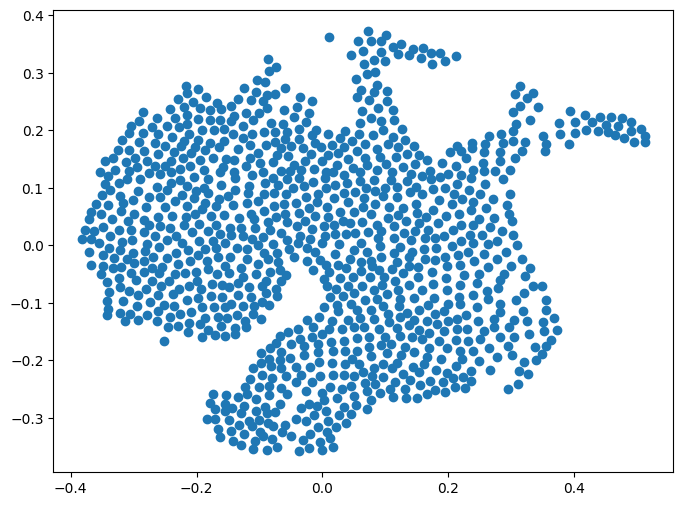

OT done


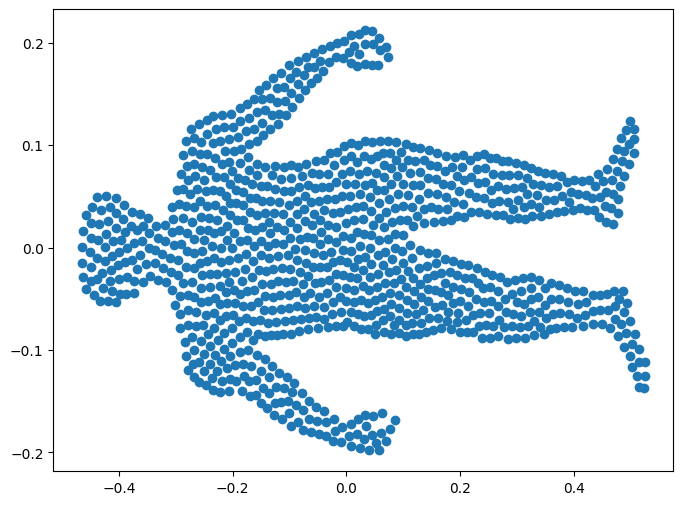

OT done


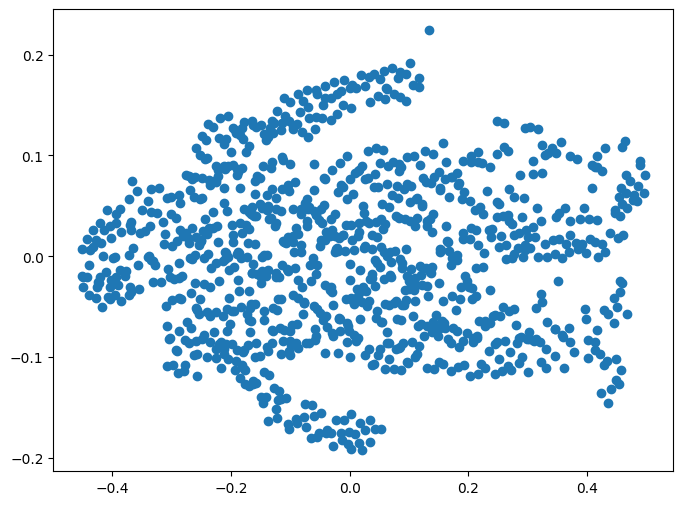

OT done


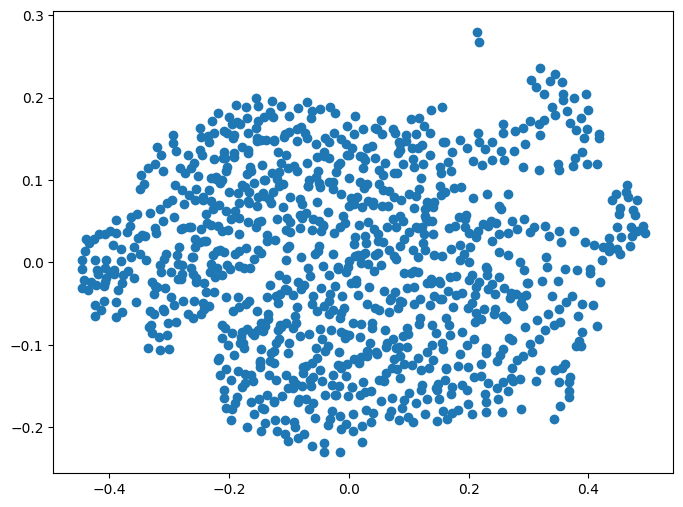

OT done


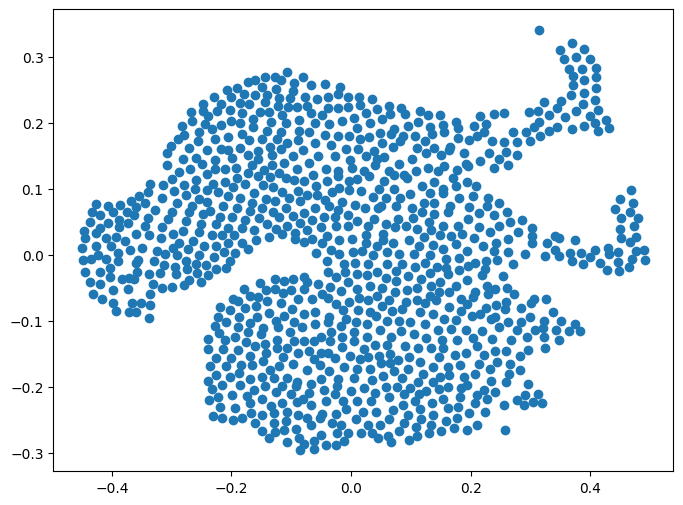

OT done


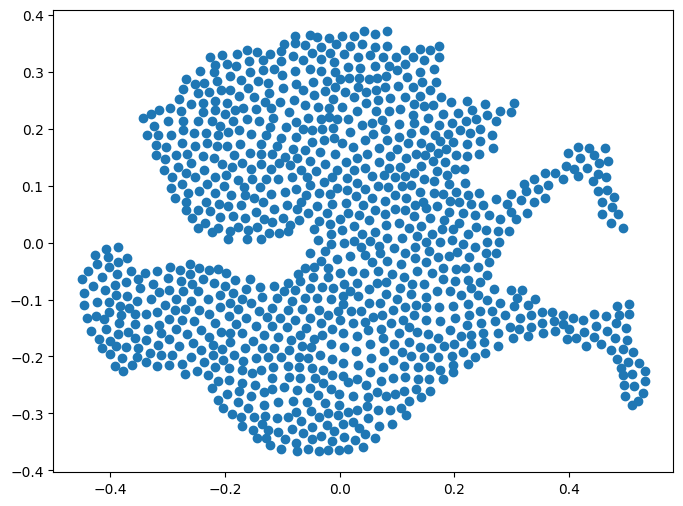

OT done


In [361]:
# Define the number of interpolation points
T=5
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


a_list = np.linspace(0, 1,T)
b_list = np.linspace(0, 1,T)

ot_result_orig,ot_result=np.zeros((T,T,N,d)),np.zeros((T,T,N,2))
gw_result_orig,gw_result=np.zeros((T,T,N,N)),np.zeros((T,T,N,2))
pgw_result_orig,pgw_result=np.zeros((T,T,N,N)),np.zeros((T,T,N,2))


# Fit PCA on the 3D data and transform it to 2D
reg=1
for i,a in enumerate(np.linspace(0, 1,T)):
    for j,b in enumerate(np.linspace(0, 1,T)):
        # lambdas=np.concatenate(((1-a)*np.array([1-b,b]),a*np.array([1-b,b])))
        # # OT barycenter
        # X_list1=[embed_d(X,d) for X in X_list]
        # p_list1=[p/p.sum() for p in p_list]
        
        # X = ot.lp.free_support_barycenter(X_list1,p_list1,X_init=X_init,b=p_init,weights=lambdas,numItermax=100,stopThr=1e-07)
        # X_2d=pca.fit_transform(X)
        # ot_result_orig[i,j]=X
        # ot_result[i,j]=X_2d

        # # Create the plot
        # plt.figure(figsize=(8, 6))  # Set figure size
        # plt.scatter(X_2d[:,0], X_2d[:,1])  # Line plot with label and line width
        # plt.show()

        # print('OT done')

        # #GW barycenter
        # p_list1=[p/p.sum() for p in p_list]
        # C=ot.gromov.gromov_barycenters(N=N, Cs=C_list, ps=p_list1, p=p_init, lambdas=lambdas,init_C=C_init, loss_fun='square_loss',
        #     symmetric=True, armijo=False, max_iter=100, tol=1e-5)
        # X_2d=smacof_mds(C,2)
        # X_2d=pca.fit_transform(X_2d.copy())
        # gw_result_orig[i,j]=C
        # gw_result[i,j]=X_2d

        # plt.figure(figsize=(8, 6))  # Set figure size
        # plt.scatter(X_2d[:,0], X_2d[:,1])  # Line plot with label and line width
        # plt.show()

        # print('GW done')

        #  #PGW barycenter  
        # C=pgw_barycenters(N=N, Cs=C_list, ps=p_list, p=p_init, Lambda_list=1*np.ones(K), lambdas=lambdas,init_C=C_init, loss_fun='square_loss', max_iter=100, tol=1e-5)
        # X_2d=smacof_mds(C,2)
        # X_2d=pca.fit_transform(X_2d.copy())
        # pgw_result_orig[i,j]=C
        # pgw_result[i,j]=X_2d
        
        # plt.figure(figsize=(8, 6))  # Set figure size
        # plt.scatter(X_2d[:,0], X_2d[:,1])  # Line plot with label and line width
        # plt.show()
        # print('PGW done')

eta=0
np.savez("interpolation/result/%i_ot.npz"%(eta), result_orig=ot_result_orig,result=ot_result)
# np.savez("interpolation/result/%i_gw.npz"%(eta), result_orig=gw_result_orig,result=gw_result)
# np.savez("interpolation/result/%i_pgw.npz"%(eta), result_orig=pgw_result_orig,result=pgw_result)


        
        

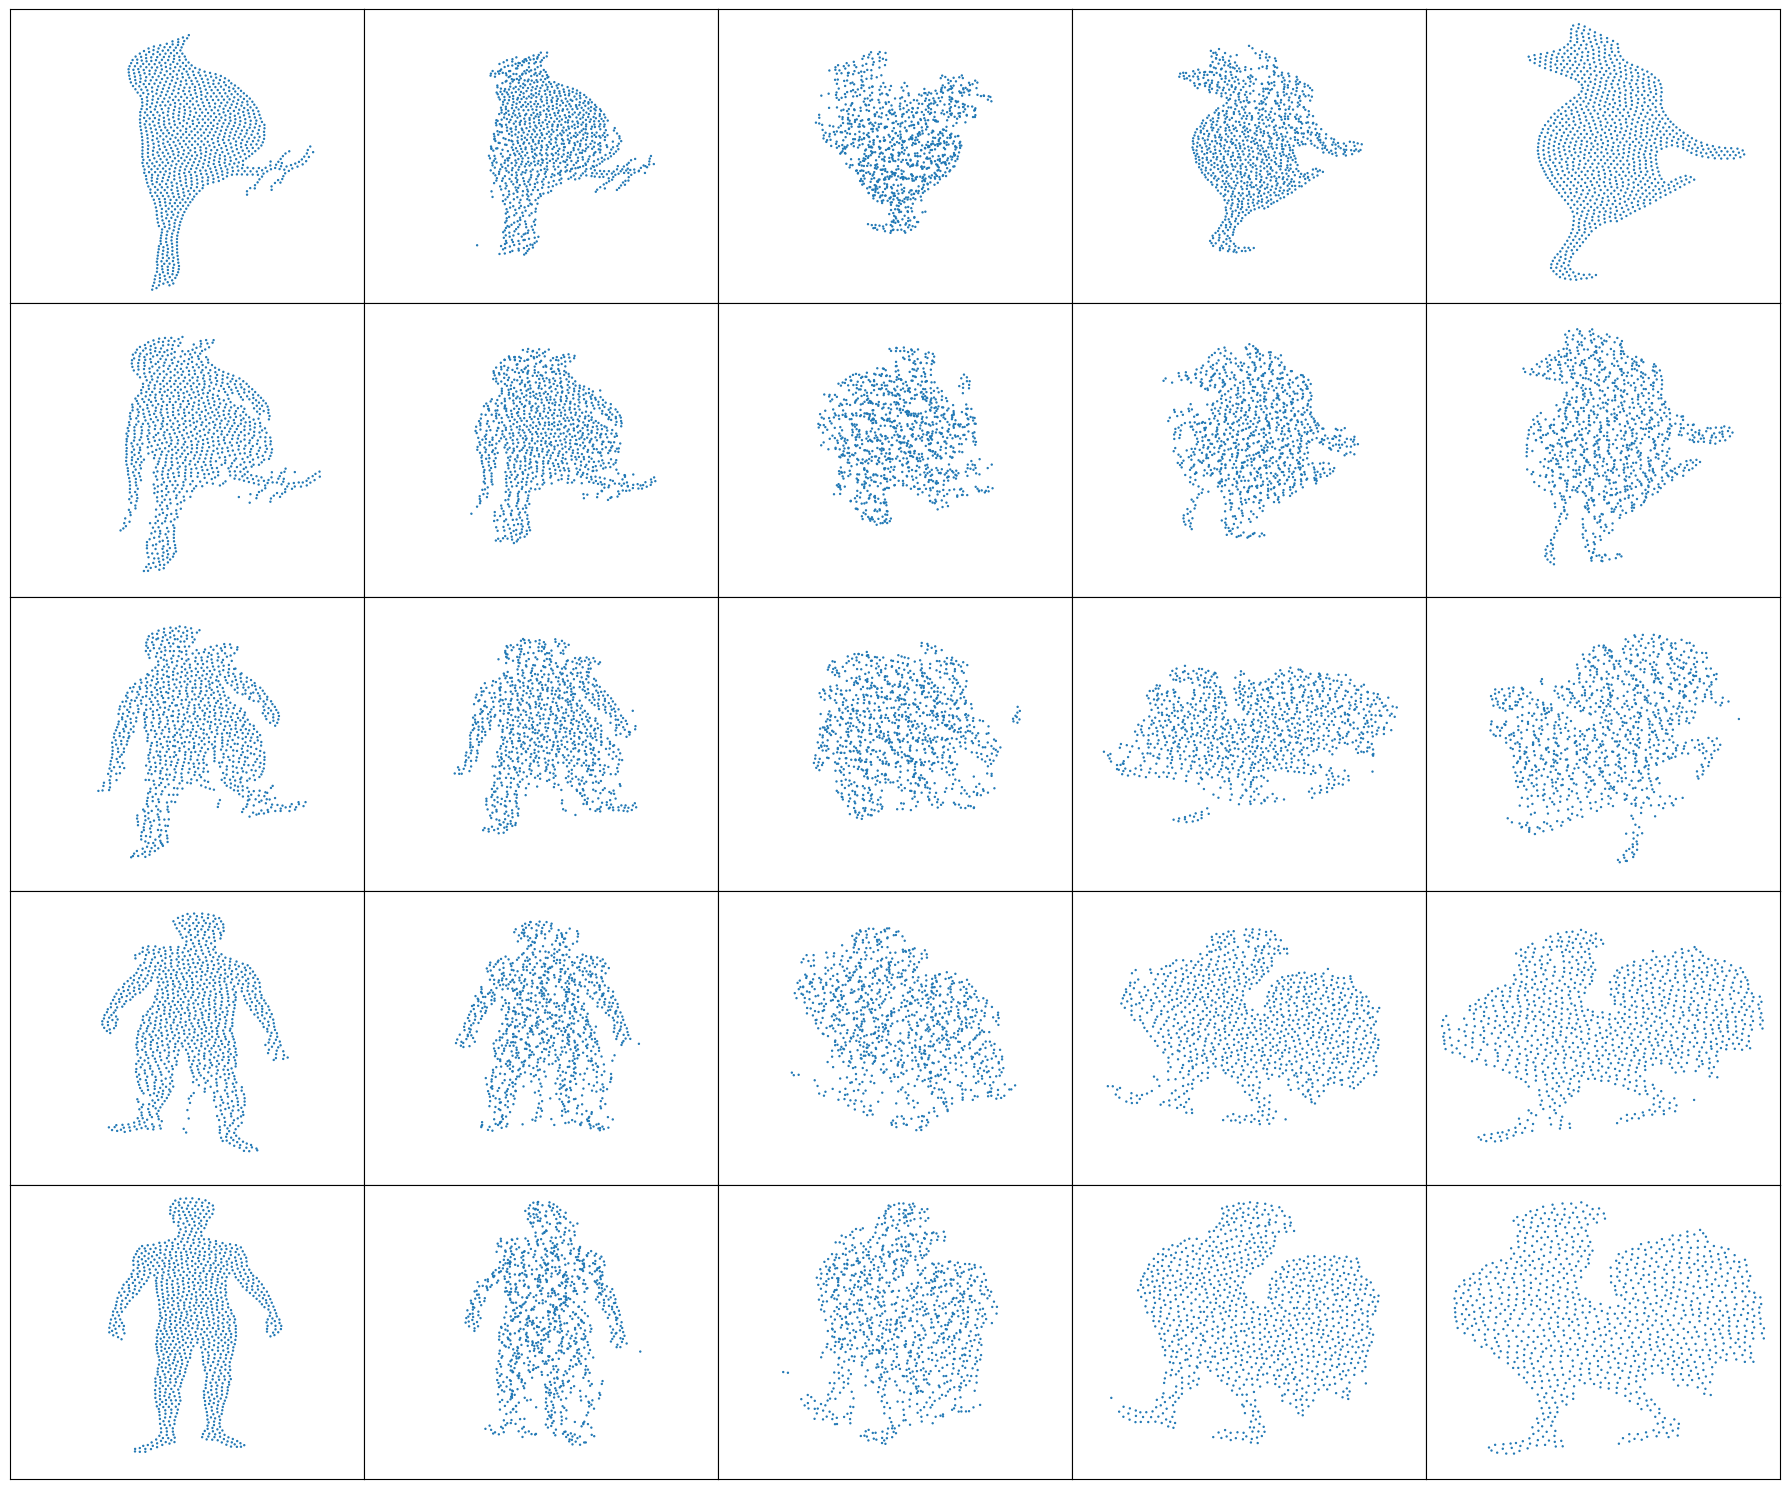

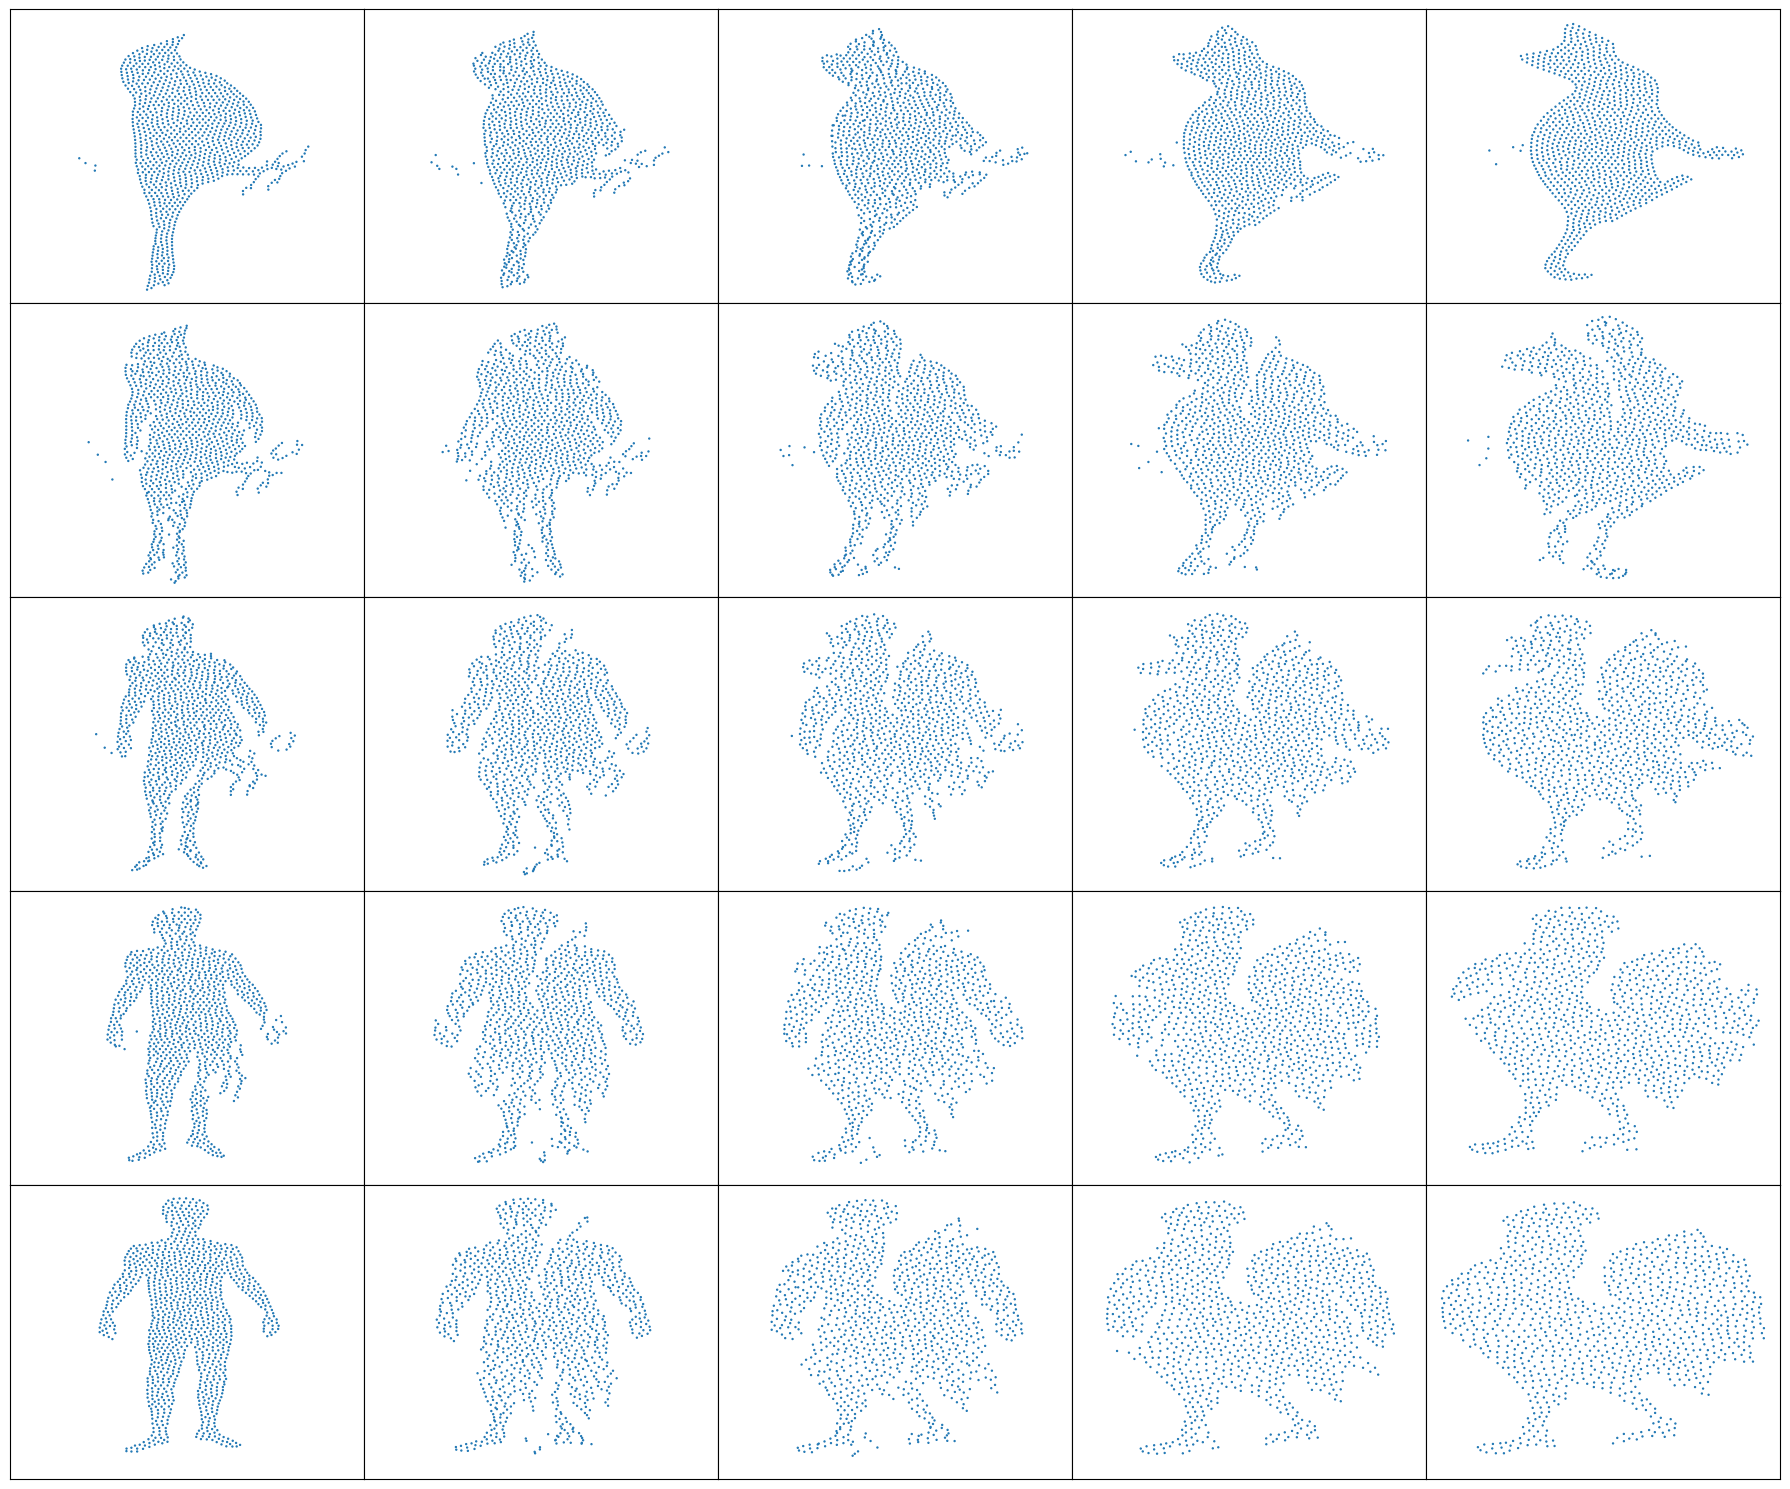

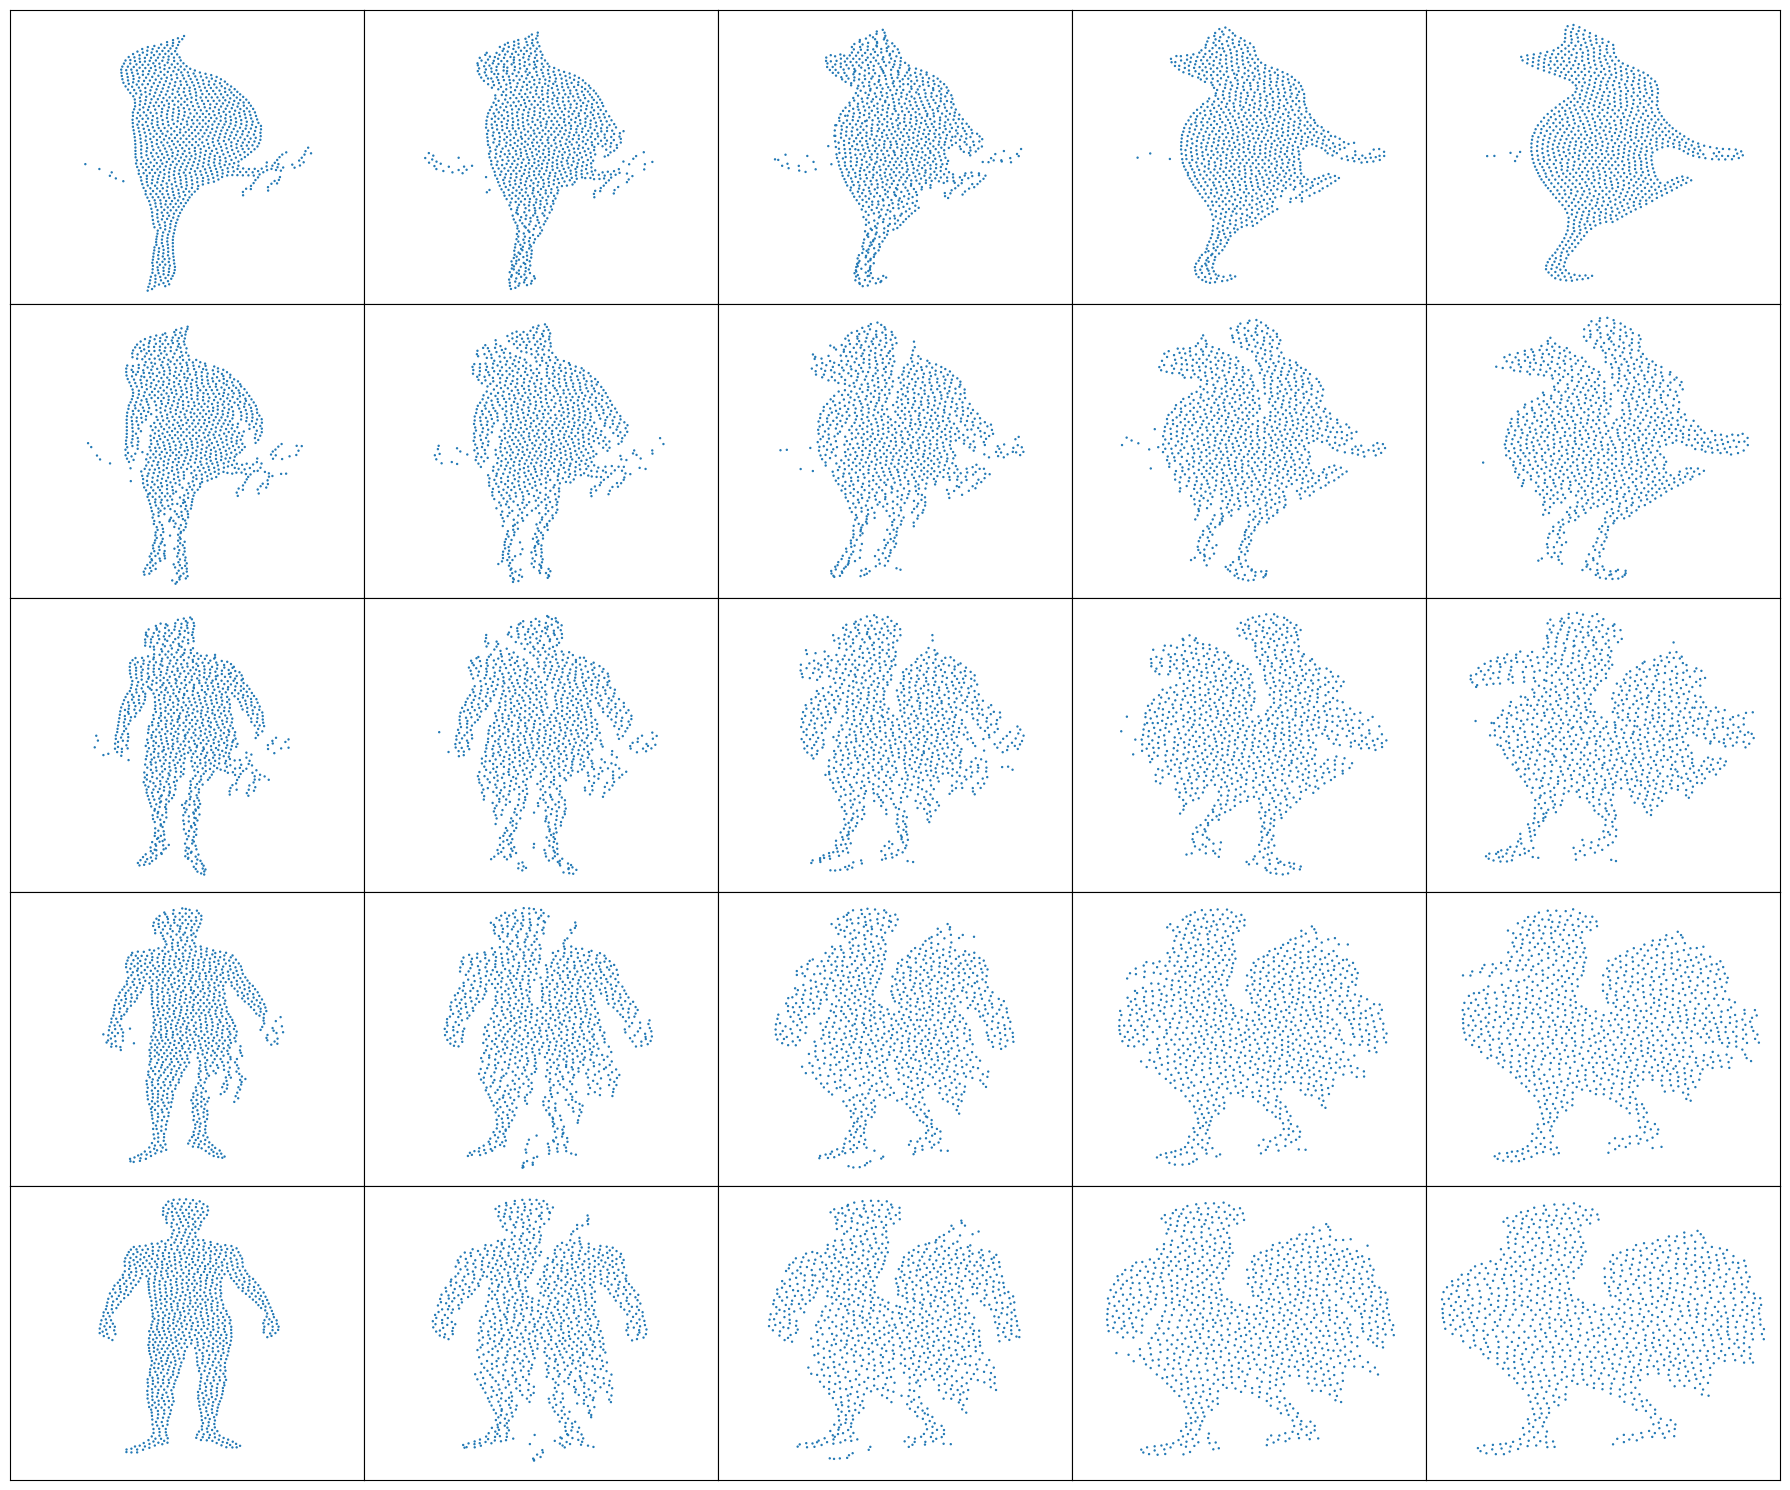

In [419]:
import matplotlib.pyplot as plt
import numpy as np

def rotation_2d(angle):
    """
    Computes a 2D rotation matrix.

    Parameters:
    angle (float): The rotation angle in radians.

    Returns:
    numpy.ndarray: A 2x2 rotation matrix.
    """
    return np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle),  np.cos(angle)]
    ])

def flipping(x=True):
    if x:
        return np.array([[0,1],[1,0]])
    else:
        return np.array([[1,0],[0,1]])

def shape_process(X,method,idx):
    angle=0.5*np.pi
    R=rotation_2d(angle)
    X1=X.dot(R)
    if method=='ot':
        if idx in ([[2,1],[2,4],[3,2],[3,3],[4,2],[4,3]]):
            X1=X1.dot(flipping(True))


        if idx in [[2,4]]:
            X1=X1.dot(rotation_2d(-0.4*np.pi))
        if idx in [[3,2],[3,3]]:
            X1=X1.dot(rotation_2d(-0.6*np.pi))
        if idx in [[2,1],[4,2],[4,3]]:
            X1=X1.dot(rotation_2d(-0.5*np.pi))
        if idx in [[3,4]]:
            X1=X1.dot(rotation_2d(0.3*np.pi))
        if idx in [[2,3]]:
            X1=X1.dot(rotation_2d(0.4*np.pi))
            
        # if idx in [[2,3],[2,4]]:
        #     X1=X1.dot(rotation_2d(0.4*np.pi))

    if method=='gw':
        if idx in ([[3,1],[3,3]]):
            X1=X1.dot(flipping(True))
        if idx in ([[3,1],[3,3]]):
            X1=X1.dot(rotation_2d(-0.5*np.pi))
    if method=='pgw':
        if idx in ([0,1],[4,1]): # ([[0,1],[4,1],[2,3]]):
            X1=X1.dot(flipping(True))
            
        if idx in ([[0,1],[4,1]]):
            X1=X1.dot(rotation_2d(-0.5*np.pi))
    return X1

    
        
        
angle=0.8*np.pi
R=rotation_2d(angle)
# Create a 5x6 grid of subplots
for method in ['ot','gw','pgw']:
    result=np.load('interpolation/result/0_%s.npz'%method)
    result_orig,result_2d=result['result_orig'],result['result']
        
    fig, axes = plt.subplots(5, 5, figsize=(18, 15), sharex=True, sharey=True)
    
    # Example: Fill each subplot with random scatter points
    for i in range(5):
        for j in range(5):
            shape=result_2d[i,j]
            shape=shape_process(shape,method,[i,j])
            ax = axes[i, j]
            ax.scatter(shape[:,0], shape[:,1],s=p_init*500)
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_yticks([])  # Remove y-axis ticks
    plt.tight_layout()  # Adjust layout for better spacing
    plt.subplots_adjust(wspace=0, hspace=0)
    
    #fig.suptitle(method.upper(), fontsize=30)
    plt.savefig('interpolation/result/0_%s.png'%method, dpi=300, bbox_inches='tight')
    plt.savefig('interpolation/result/0_%s.pdf'%method, dpi=300, bbox_inches='tight')
    
    # for i in range(4):
    #     ax =axes[i,0]
    #     ax.scatter(shape[:,0], shape[:,1])
    plt.show()

In [53]:
X_list,C_list,p_list=[],[],[]
N=1024
for idx,i in enumerate([0,1,3,4]):
    X=noise_5[i]
    if idx%2==1:
        np.random.seed(idx)
        X1=embed_d2(X,d)
        random_matrix = np.random.randn(d, d)
        q, _ = np.linalg.qr(random_matrix)
        X1=X1.dot(q)
#        print('theta is',theta)
    else:
        X1=X
    if idx in [0,2]:
        X1=X1[0:N]
    C=np.sqrt(cost_matrix_d(X1,X1))
    C_max=max_list[idx]
    X1=X1/C_max
    C1=C/C_max
    X_list.append(X1)
    C_list.append(C1)
    p=np.ones(X1.shape[0])/N
    p_list.append(p.copy())


    


# construct initial guess

X_init = np.random.rand(N, d)  # initial Dirac locations
C_init=np.sqrt(cost_matrix_d(X_init,X_init))
X_init/=C_init.max()
C_init/=C_init.max()
p_init=np.ones(N)/N

In [54]:
for p in p_list:
    print(p.sum())

1.0
1.0498046875
1.0
1.0498046875


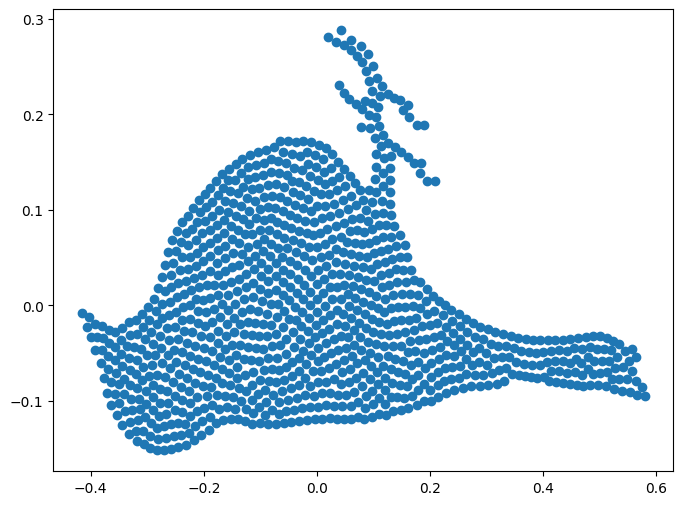

OT done


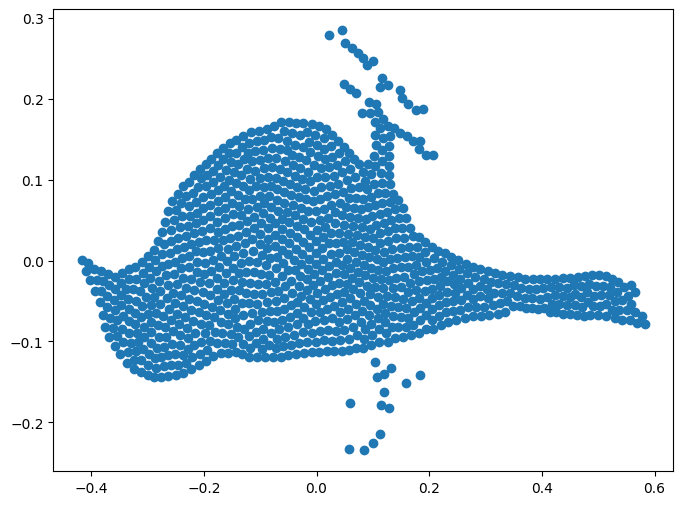

GW done


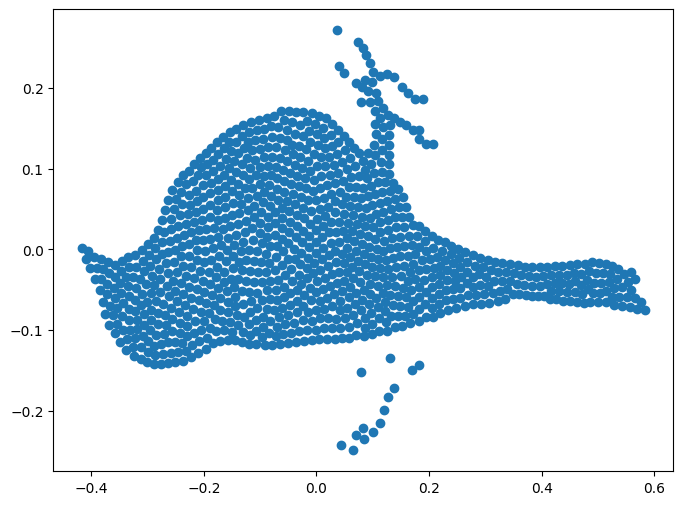

PGW done


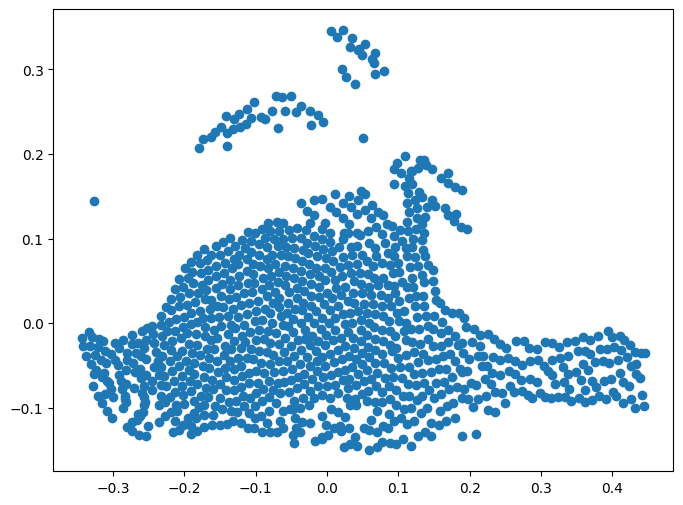

OT done


In [ ]:
# Define the number of interpolation points
T=5
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


ot_result_orig,ot_result=np.zeros((T,T,N,d)),np.zeros((T,T,N,2))
gw_result_orig,gw_result=np.zeros((T,T,N,N)),np.zeros((T,T,N,2))
pgw_result_orig,pgw_result=np.zeros((T,T,N,N)),np.zeros((T,T,N,2))

K=4
# Fit PCA on the 3D data and transform it to 2D
reg=1
for i,a in enumerate(np.linspace(0, 1,T)):
    for j,b in enumerate(np.linspace(0, 1,T)):
        lambdas=np.concatenate(((1-a)*np.array([1-b,b]),a*np.array([1-b,b])))
        
        # OT barycenter
        X_list1=[embed_d(X,d) for X in X_list]
        p_list1=[p/p.sum() for p in p_list]
        
        X = ot.lp.free_support_barycenter(X_list1,p_list1,X_init=X_init,b=p_init,weights=lambdas,numItermax=100,stopThr=1e-07)
        X_2d=pca.fit_transform(X)
        ot_result_orig[i,j]=X
        ot_result[i,j]=X_2d

        # Create the plot
        plt.figure(figsize=(8, 6))  # Set figure size
        plt.scatter(X_2d[:,0], X_2d[:,1])  # Line plot with label and line width
        plt.show()

        print('OT done')

        

        #GW barycenter
        p_list1=[p/p.sum() for p in p_list]
        C=ot.gromov.gromov_barycenters(N=N, Cs=C_list, ps=p_list1, p=p_init, lambdas=lambdas,init_C=C_init, loss_fun='square_loss',
            symmetric=True, armijo=False, max_iter=100, tol=1e-5)
        X_2d=smacof_mds(C,2)
        X_2d=pca.fit_transform(X_2d.copy())
        gw_result_orig[i,j]=C
        gw_result[i,j]=X_2d

        plt.figure(figsize=(8, 6))  # Set figure size
        plt.scatter(X_2d[:,0], X_2d[:,1])  # Line plot with label and line width
        plt.show()

        print('GW done')

         #PGW barycenter  
        C=pgw_barycenters(N=N, Cs=C_list, ps=p_list, p=p_init, Lambda_list=1*np.ones(K), lambdas=lambdas,init_C=C_init, loss_fun='square_loss', max_iter=100, tol=1e-5)
        X_2d=smacof_mds(C,2)
        X_2d=pca.fit_transform(X_2d.copy())
        pgw_result_orig[i,j]=C
        pgw_result[i,j]=X_2d
        
        plt.figure(figsize=(8, 6))  # Set figure size
        plt.scatter(X_2d[:,0], X_2d[:,1])  # Line plot with label and line width
        plt.show()
        print('PGW done')

eta=10
np.savez("interpolation/result/%i_ot.npz"%(eta), result_orig=ot_result_orig,result=ot_result)
np.savez("interpolation/result/%i_gw.npz"%(eta), result_orig=gw_result_orig,result=gw_result)
np.savez("interpolation/result/%i_pgw.npz"%(eta), result_orig=pgw_result_orig,result=pgw_result)


In [49]:
p_list[2].sum()

1.099609375

In [48]:
p_init.sum()

1.0